Faz download do dataset

In [ ]:
!rm -rf rivet_dataset
!git clone https://github.com/guipiveti/rivet_dataset

Cloning into 'rivet_dataset'...
remote: Enumerating objects: 2523, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2523 (delta 0), reused 2 (delta 0), pack-reused 2520
Receiving objects: 100% (2523/2523), 773.19 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (2499/2499), done.


#Faz as importações necessárias

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage import io
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte, invert, img_as_float
from skimage.filters import try_all_threshold, threshold_minimum
from skimage.morphology import binary_erosion
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage.segmentation import clear_border

#Analisa os rebites fraturados



In [ ]:
fratData = pd.DataFrame(columns=["number_of_contours", "area", "perimeter", "circularity"])

# 80%
for i in range(37):
  
  # Loads Image
  file_name = '/content/rivet_dataset/Original/Fraturadas/frat ('+str(i+1)+').bmp'
  image = io.imread(file_name)
  image = image[50:950,0:1000]

  # Converts to binary
  thresh_min = threshold_minimum(image)
  binary_image = image > thresh_min

  # Erode to filter remaining pixels
  binary_image = binary_erosion(binary_image)

  # Shows Result
  # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)
  # plt.show()

  edges = canny(binary_image, sigma=3)


  # Encontra a lata
  hough_radii = np.arange(318, 326, 2)
  hough_res = hough_circle(edges, hough_radii)
  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
  # ax[0].set_title('Binary Image')
  # ax[0].imshow(binary_image, cmap=plt.cm.gray)
  image = color.gray2rgb(image)
  # for center_y, center_x, radius in zip(cy, cx, radii):
  #     print(radius)
  #     circy, circx = circle_perimeter(center_y, center_x, radius, shape=binary_image.shape)
  #     image[circy, circx] = (220, 20, 20)
  # ax[1].set_title('Edge')
  # ax[1].imshow(image, cmap=plt.cm.gray)
  # plt.show()


  for center_y, center_x, radius in zip(cy, cx, radii):
    # print(radius)
    circy, circx = circle_perimeter(center_y, center_x, radius-115, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)
    circy, circx = circle_perimeter(center_y, center_x, radius-50, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)

  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

  # ax[0].set_title('ROI')
  # ax[0].imshow(image, cmap=plt.cm.gray)


  hough_radii = np.arange(20, 35, 2)
  hough_res = hough_circle(edges, hough_radii)

  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                            total_num_peaks=1)

  image = color.gray2rgb(image)
  for center_y, center_x, radius in zip(cy, cx, radii):
      circy, circx = circle_perimeter(center_y, center_x, radius,
                                      shape=image.shape)
      image[circy, circx] = (220, 20, 20)
      # ax[1].imshow(image, cmap=plt.cm.gray)
      # plt.show()

      # Gets ROI of the rivet
      min_x = center_x - radius
      max_x = center_x + radius
      min_y = center_y - radius
      max_y = center_y + radius

      # print(min_x, min_y, max_x, max_y)
      
      binary_image = binary_image[min_y:max_y,min_x:max_x]
      image = image[min_y:max_y,min_x:max_x]
  # fig, ax = plt.subplots(figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)


  labels = label(binary_image)
  # image_label_overlay = label2rgb(labels, image=image, bg_label=0)
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(image_label_overlay)
  # remove artifacts connected to image border
  cleared = clear_border(labels)
  # to make the background transparent, pass the value of `bg_label`,
  # and leave `bg_color` as `None` and `kind` as `overlay`
  image_label_overlay = label2rgb(labels, image=image, bg_label=0, bg_color=None, kind='overlay')
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(cleared)

  # FOUND THE RIVET. NOW WE SHOULD ANALYSE IT.
  rivet_area=0
  number_of_contours=0
  rivet_perimeter=0
  circularity=0
  for region in regionprops(cleared):
    rivet_area+=region.area
    number_of_contours+=1
    rivet_perimeter+=region.perimeter
  
  fratData = fratData.append({'number_of_contours': number_of_contours, 'area': rivet_area, 'perimeter': rivet_perimeter, 'circularity': circularity}, ignore_index=True)

fratData.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


,number_of_contours,area,perimeter,circularity
count,37.000000,37.000000,37.000000,37.0
mean,1.189189,554.054054,92.805115,0.0
std,0.461750,32.881898,6.000292,0.0
min,1.000000,477.000000,83.012193,0.0
25%,1.000000,535.000000,88.183766,0.0
50%,1.000000,556.000000,91.461941,0.0
75%,1.000000,574.000000,97.012193,0.0
max,3.000000,621.000000,106.982756,0.0


#Analisa os rebites não fraturados

In [ ]:
nFratData = pd.DataFrame(columns=["number_of_contours", "area", "perimeter", "circularity"])

def get_ring(image, center, rmin, rmax):
    h,w = image.shape
    cy,cx = center
    g = np.copy(image)
    ys,xs = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    rmin2 = rmin**2
    rmax2 = rmax**2
    dist2 = (xs-cx)**2 + (ys-cy)**2
    mask = (dist2 <= rmin2) | (dist2 >= rmax2)
    g[mask] = 0.0
    return g

# 80%
for i in range(88):
  
  # Loads Image
  file_name = '/content/rivet_dataset/Original/Nao_Fraturadas/nfrat ('+str(i+1)+').bmp'
  image = io.imread(file_name)
  image = image[50:950,0:1000]

  # Converts to binary
  thresh_min = threshold_minimum(image)
  binary_image = image > thresh_min

  # Erode to filter remaining pixels
  binary_image = binary_erosion(binary_image)

  # Shows Result
  # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)
  # plt.show()

  edges = canny(binary_image, sigma=3)


  # Encontra a lata
  hough_radii = np.arange(318, 326, 2)
  hough_res = hough_circle(edges, hough_radii)
  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
  # ax[0].set_title('Binary Image')
  # ax[0].imshow(binary_image, cmap=plt.cm.gray)
  image = color.gray2rgb(image)
  # for center_y, center_x, radius in zip(cy, cx, radii):
  #     print(radius)
  #     circy, circx = circle_perimeter(center_y, center_x, radius, shape=binary_image.shape)
  #     image[circy, circx] = (220, 20, 20)
  # ax[1].set_title('Edge')
  # ax[1].imshow(image, cmap=plt.cm.gray)
  # plt.show()



  for center_y, center_x, radius in zip(cy, cx, radii):
    # print(radius)
    circy, circx = circle_perimeter(center_y, center_x, radius-115, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)
    circy, circx = circle_perimeter(center_y, center_x, radius-50, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)

  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

  # ax[0].set_title('ROI')
  # ax[0].imshow(image, cmap=plt.cm.gray)


  center = (np.array(edges.shape)/2)
  image_ring = get_ring(edges, center, radius-115, radius-50)

  hough_radii = np.arange(20, 35, 2)
  hough_res = hough_circle(image_ring, hough_radii)

  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                            total_num_peaks=1)

  image = color.gray2rgb(image)
  for center_y, center_x, radius in zip(cy, cx, radii):
      circy, circx = circle_perimeter(center_y, center_x, radius,
                                      shape=image.shape)
      image[circy, circx] = (220, 20, 20)
      # ax[1].imshow(image, cmap=plt.cm.gray)
      # plt.show()

      # Gets ROI of the rivet
      min_x = center_x - radius
      max_x = center_x + radius
      min_y = center_y - radius
      max_y = center_y + radius

      # print(min_x, min_y, max_x, max_y)
      
      binary_image = binary_image[min_y:max_y,min_x:max_x]
      image = image[min_y:max_y,min_x:max_x]
  # fig, ax = plt.subplots(figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)


  labels = label(binary_image)
  # image_label_overlay = label2rgb(labels, image=image, bg_label=0)
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(image_label_overlay)
  # remove artifacts connected to image border
  cleared = clear_border(labels)
  # to make the background transparent, pass the value of `bg_label`,
  # and leave `bg_color` as `None` and `kind` as `overlay`
  image_label_overlay = label2rgb(labels, image=image, bg_label=0, bg_color=None, kind='overlay')
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(cleared)

  # FOUND THE RIVET. NOW WE SHOULD ANALYSE IT.
  rivet_area=0
  number_of_contours=0
  rivet_perimeter=0
  circularity=0
  for region in regionprops(cleared):
    rivet_area+=region.area
    number_of_contours+=1
    rivet_perimeter+=region.perimeter
  
  nFratData = nFratData.append({'number_of_contours': number_of_contours, 'area': rivet_area, 'perimeter': rivet_perimeter, 'circularity': circularity}, ignore_index=True)

nFratData.describe()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


,number_of_contours,area,perimeter,circularity
count,88.0,88.000000,88.000000,88.0
mean,1.0,617.931818,90.505341,0.0
std,0.0,12.693374,1.106773,0.0
min,1.0,596.000000,87.597980,0.0
25%,1.0,607.750000,89.597980,0.0
50%,1.0,614.500000,90.426407,0.0
75%,1.0,628.000000,91.254834,0.0
max,1.0,646.000000,92.669048,0.0


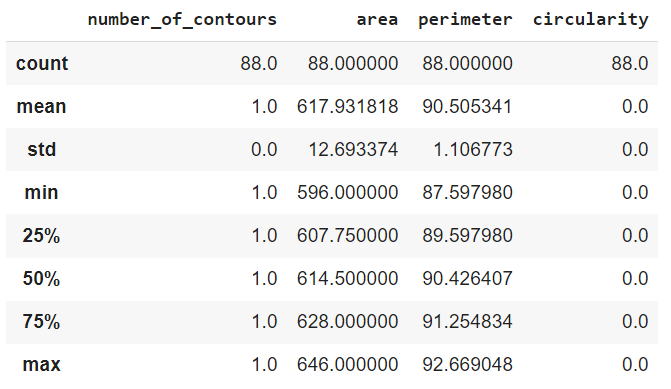
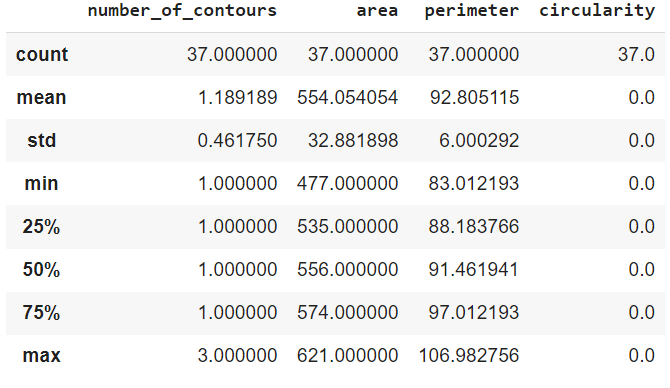

Árvore de decisão:


*   Número de contornos = 1
*   595 < Área < 650
*   86  < Perímetro < 93



#Valida a árvore de decisão com rebites não fraturados

In [ ]:
true_nfrat = 0
error_nfrat = 0

# 20%
for i in range(23):
  
  # Loads Image
  file_name = '/content/rivet_dataset/Original/Nao_Fraturadas/nfrat ('+str(i+89)+').bmp'
  image = io.imread(file_name)
  image = image[50:950,0:1000]

  # Converts to binary
  thresh_min = threshold_minimum(image)
  binary_image = image > thresh_min

  # Erode to filter remaining pixels
  binary_image = binary_erosion(binary_image)

  # Shows Result
  # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)
  # plt.show()

  edges = canny(binary_image, sigma=3)


  # Encontra a lata
  hough_radii = np.arange(318, 326, 2)
  hough_res = hough_circle(edges, hough_radii)
  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
  # ax[0].set_title('Binary Image')
  # ax[0].imshow(binary_image, cmap=plt.cm.gray)
  image = color.gray2rgb(image)
  # for center_y, center_x, radius in zip(cy, cx, radii):
  #     print(radius)
  #     circy, circx = circle_perimeter(center_y, center_x, radius, shape=binary_image.shape)
  #     image[circy, circx] = (220, 20, 20)
  # ax[1].set_title('Edge')
  # ax[1].imshow(image, cmap=plt.cm.gray)
  # plt.show()





  for center_y, center_x, radius in zip(cy, cx, radii):
    # print(radius)
    circy, circx = circle_perimeter(center_y, center_x, radius-115, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)
    circy, circx = circle_perimeter(center_y, center_x, radius-50, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)

  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

  # ax[0].set_title('ROI')
  # ax[0].imshow(image, cmap=plt.cm.gray)

  #*****#*****#*****#*****#*****#*****#*****#*****
  center = (np.array(edges.shape)/2)#*****
  # print("center: ", center)
  image_ring = get_ring(edges, center, radius-115, radius-50)#*****
  #*****#*****#*****#*****#*****#*****#*****#*****

  # TODOOOOOOOOOO: Limitar região do Hought
  hough_radii = np.arange(20, 35, 2)
  hough_res = hough_circle(image_ring, hough_radii)#*****

  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                            total_num_peaks=1)

  image = color.gray2rgb(image)
  for center_y, center_x, radius in zip(cy, cx, radii):
      circy, circx = circle_perimeter(center_y, center_x, radius,
                                      shape=image.shape)
      image[circy, circx] = (220, 20, 20)
      # ax[1].imshow(image, cmap=plt.cm.gray)
      # plt.show()

      # Gets ROI of the rivet
      min_x = center_x - radius
      max_x = center_x + radius
      min_y = center_y - radius
      max_y = center_y + radius

      # print(min_x, min_y, max_x, max_y)
      
      binary_image = binary_image[min_y:max_y,min_x:max_x]
      image = image[min_y:max_y,min_x:max_x]
  # fig, ax = plt.subplots(figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)




  # TODO: SE COPIAR O TRECHO ABAIXO SEMCOM O INVERT PODEMOS VERIFICAR A ÁREA ENTRE A TAMPA E O REBITE
  # binary_image = invert(binary_image)
  labels = label(binary_image)
  # image_label_overlay = label2rgb(labels, image=image, bg_label=0)
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(image_label_overlay)
  # remove artifacts connected to image border
  cleared = clear_border(labels)
  # to make the background transparent, pass the value of `bg_label`,
  # and leave `bg_color` as `None` and `kind` as `overlay`
  image_label_overlay = label2rgb(labels, image=image, bg_label=0, bg_color=None, kind='overlay')
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(cleared)




  # FOUND THE RIVET. NOW WE SHOULD ANALYSE IT.
  rivet_area=0
  number_of_contours=0
  rivet_perimeter=0
  circularity=0
  for region in regionprops(cleared):
    rivet_area+=region.area
    number_of_contours+=1
    rivet_perimeter+=region.perimeter
  if(number_of_contours==1) and (rivet_area<650 and 595<rivet_area) and (rivet_perimeter<93 and 86<rivet_perimeter):
    true_nfrat += 1
  else:
    error_nfrat += 1
  
print('true_nfrat')
print(true_nfrat)
print('error_nfrat')
print(error_nfrat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


true_nfrat
23
error_nfrat
0


#Valida a árvore de decisão com rebites fraturados

In [ ]:
true_frat = 0
error_frat = 0

# 20%
for i in range(10):
  
  # Loads Image
  file_name = '/content/rivet_dataset/Original/Fraturadas/frat ('+str(i+38)+').bmp'
  image = io.imread(file_name)
  image = image[50:950,0:1000]

  # Converts to binary
  thresh_min = threshold_minimum(image)
  binary_image = image > thresh_min

  # Erode to filter remaining pixels
  binary_image = binary_erosion(binary_image)

  # Shows Result
  # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)
  # plt.show()

  edges = canny(binary_image, sigma=3)


  # Encontra a lata
  hough_radii = np.arange(318, 326, 2)
  hough_res = hough_circle(edges, hough_radii)
  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
  # ax[0].set_title('Binary Image')
  # ax[0].imshow(binary_image, cmap=plt.cm.gray)
  image = color.gray2rgb(image)
  # for center_y, center_x, radius in zip(cy, cx, radii):
  #     print(radius)
  #     circy, circx = circle_perimeter(center_y, center_x, radius, shape=binary_image.shape)
  #     image[circy, circx] = (220, 20, 20)
  # ax[1].set_title('Edge')
  # ax[1].imshow(image, cmap=plt.cm.gray)
  # plt.show()





  for center_y, center_x, radius in zip(cy, cx, radii):
    # print(radius)
    circy, circx = circle_perimeter(center_y, center_x, radius-115, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)
    circy, circx = circle_perimeter(center_y, center_x, radius-50, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)

  # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

  # ax[0].set_title('ROI')
  # ax[0].imshow(image, cmap=plt.cm.gray)

  #*****#*****#*****#*****#*****#*****#*****#*****
  center = (np.array(edges.shape)/2)#*****
  # print("center: ", center)
  image_ring = get_ring(edges, center, radius-115, radius-50)#*****
  #*****#*****#*****#*****#*****#*****#*****#*****

  # TODOOOOOOOOOO: Limitar região do Hought
  hough_radii = np.arange(20, 35, 2)
  hough_res = hough_circle(image_ring, hough_radii)#*****

  accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                            total_num_peaks=1)

  image = color.gray2rgb(image)
  for center_y, center_x, radius in zip(cy, cx, radii):
      circy, circx = circle_perimeter(center_y, center_x, radius,
                                      shape=image.shape)
      image[circy, circx] = (220, 20, 20)
      # ax[1].imshow(image, cmap=plt.cm.gray)
      # plt.show()

      # Gets ROI of the rivet
      min_x = center_x - radius
      max_x = center_x + radius
      min_y = center_y - radius
      max_y = center_y + radius

      # print(min_x, min_y, max_x, max_y)
      
      binary_image = binary_image[min_y:max_y,min_x:max_x]
      image = image[min_y:max_y,min_x:max_x]
  # fig, ax = plt.subplots(figsize=(10, 4))
  # ax.imshow(binary_image, cmap=plt.cm.gray)




  # TODO: SE COPIAR O TRECHO ABAIXO SEMCOM O INVERT PODEMOS VERIFICAR A ÁREA ENTRE A TAMPA E O REBITE
  # binary_image = invert(binary_image)
  labels = label(binary_image)
  # image_label_overlay = label2rgb(labels, image=image, bg_label=0)
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(image_label_overlay)
  # remove artifacts connected to image border
  cleared = clear_border(labels)
  # to make the background transparent, pass the value of `bg_label`,
  # and leave `bg_color` as `None` and `kind` as `overlay`
  image_label_overlay = label2rgb(labels, image=image, bg_label=0, bg_color=None, kind='overlay')
  # fig, ax = plt.subplots(figsize=(10, 6))
  # ax.imshow(cleared)




  # FOUND THE RIVET. NOW WE SHOULD ANALYSE IT.
  rivet_area=0
  number_of_contours=0
  rivet_perimeter=0
  circularity=0
  for region in regionprops(cleared):
    rivet_area+=region.area
    number_of_contours+=1
    rivet_perimeter+=region.perimeter
  if(number_of_contours==1) and (rivet_area<650 and 595<rivet_area) and (rivet_perimeter<93 and 86<rivet_perimeter):
    error_frat += 1
  else:
    true_frat += 1
  
print('true_frat')
print(true_frat)
print('error_frat')
print(error_frat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


true_frat
9
error_frat
1
